In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import VGG19
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten, Conv2D, Activation, MaxPooling2D
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Load images and labels
path = '/content/drive/MyDrive/Deep_learning_projects/SheepFaceImages'
sheep_breed_list = os.listdir(path)
print(sheep_breed_list)

['White Suffolk', 'Poll Dorset', 'Marino', 'Suffolk']


In [4]:
def load_and_preprocess_images(path, target_size=(224, 224)):
    img_data_list = []
    labels = []

    for idx, sheep_breed in enumerate(sheep_breed_list):
        sheep_breed_files = os.listdir(os.path.join(path, sheep_breed))
        print(sheep_breed_files)
        for img_file in sheep_breed_files:
            sheep_image_path = os.path.join(path, sheep_breed, img_file)
            try:
                img = image.load_img(sheep_image_path, target_size=target_size)
                img_array = image.img_to_array(img)
                img_array = preprocess_input(img_array)
                img_data_list.append(img_array)
                labels.append(idx)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

    # Convert lists to numpy arrays and preprocess
    img_data = np.array(img_data_list)
    labels = np.array(labels)

    # Shuffle data
    img_data, labels = shuffle(img_data, labels, random_state=777)

    return img_data, labels, sheep_breed_list

img_data_path = '/content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheep_img_data.npy'
labels_path = '/content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheep_labels.npy'

if os.path.exists(img_data_path) and os.path.exists(labels_path):
    img_data = np.load(img_data_path)
    labels = np.load(labels_path)
else:
    img_data, labels, sheep_breed_list = load_and_preprocess_images(path)
    # Save the processed data
    np.save(img_data_path, img_data)
    np.save(labels_path, labels)

print('Data Shape:', img_data.shape)
print('Labels Shape:', labels.shape)

Data Shape: (1680, 224, 224, 3)
Labels Shape: (1680,)


In [5]:
# One-hot encode labels
labels_categorical = to_categorical(labels, num_classes=len(sheep_breed_list))

print(labels_categorical.shape)

(1680, 4)


In [8]:
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze first 10 convolutional layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    x = base_model.output

    # Flatten to prepare for the fully connected layers
    x = Flatten()(x)

    # Fully connected + ReLU
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # Adding output layer
    predictions = Dense(len(sheep_breed_list), activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Custom learning rates
    lr_mult = {}

    # Set learning rate to 0 for the first 10 layers
    for layer in model.layers[:15]:
        lr_mult[layer.name + '/kernel:0'] = 0.0
        lr_mult[layer.name + '/bias:0'] = 0.0

    # Set learning rate to 0.0001 for the next Conv2D layers and the following layers
    for layer in model.layers[15:-4]:
        if isinstance(layer, Conv2D):
            lr_mult[layer.name + '/kernel:0'] = 0.0001
            lr_mult[layer.name + '/bias:0'] = 0.0001

    # Set learning rate to 10 for the last two dense layers
    for layer in model.layers[-4:]:
        lr_mult[layer.name + '/kernel:0'] = 10
        lr_mult[layer.name + '/bias:0'] = 10

    # Use SGD optimizer with initial learning rate of 1e-4
    optimizer = SGD(learning_rate=1e-4,momentum=0.9)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[1.] + [10.]*2)

    return model

accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# KFold Cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=777)
fold_var = 1

for train_index, test_index in kf.split(img_data):
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

    model = build_model()

    #early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
    save_path='/content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5'
    checkpoint = ModelCheckpoint(save_path,monitor='val_loss',save_best_only=True,verbose=1)
    history = model.fit(X_train, y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.2, callbacks=[checkpoint])

    print("\n")
    print(f'Evaluating the Test metrics')
    model=load_model(save_path)
    # Evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=1)
    print(f'Test loss for fold {fold_var}: {scores[0]}')
    print(f'Test accuracy for fold {fold_var}: {scores[1]}')

    accuracy_values.append(scores[1])  # Appending accuracy to the list

    # Get predictions from the model
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to categorical labels
    y_pred = np.argmax(model.predict(X_test), axis=1)  # Get predictions from the model

    # Calculate and append evaluation metrics for this fold
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    # Print evaluation metrics for this fold
    print(f'Precision for fold {fold_var}: {precision}')
    print(f'Recall for fold {fold_var}: {recall}')
    print(f'F1 Score for fold {fold_var}: {f1}')
    print("\n")

    train_acc_list.append(history.history['accuracy'])
    val_acc_list.append(history.history['val_accuracy'])
    train_loss_list.append(history.history['loss'])
    val_loss_list.append(history.history['val_loss'])

    # Increment the fold number
    fold_var += 1

# Calculate standard deviation of accuracy across folds
accuracy_std_dev = np.std(accuracy_values)
print(f'Standard deviation of accuracy across folds: {accuracy_std_dev}')

# Calculate average of accuracy,precision, recall, and F1 across folds
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1 = np.mean(f1_values)

print(f'Average Accuracy across folds: {avg_accuracy}')
print(f'Average Precision across folds: {avg_precision}')
print(f'Average Recall across folds: {avg_recall}')
print(f'Average F1 Score across folds: {avg_f1}')


58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/10
108/108 [==============================] - ETA: 0s - loss: 1.0960 - accuracy: 0.6521
Epoch 1: val_loss improved from inf to 0.55297, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 31s 227ms/step - loss: 1.0960 - accuracy: 0.6521 - val_loss: 0.5530 - val_accuracy: 0.7695
Epoch 2/10
107/108 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9383
Epoch 2: val_loss improved from 0.55297 to 0.21772, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 8s 75ms/step - loss: 0.1830 - accuracy: 0.9386 - val_loss: 0.2177 - val_accuracy: 0.9368
Epoch 3/10
107/108 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9953
Epoch 3: val_loss improved from 0.21772 to 0.18921, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 8s 75ms/step - loss: 0.0265 - accuracy: 0.9953 - val_loss: 0.1892 - val_accuracy: 0.9331
Epoch 4/10
107/108 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9991
Epoch 4: val_loss impr

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 11s 91ms/step - loss: 1.1376 - accuracy: 0.6660 - val_loss: 0.4511 - val_accuracy: 0.8104
Epoch 2/10
107/108 [============================>.] - ETA: 0s - loss: 0.1745 - accuracy: 0.9402
Epoch 2: val_loss improved from 0.45110 to 0.31211, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 8s 78ms/step - loss: 0.1738 - accuracy: 0.9405 - val_loss: 0.3121 - val_accuracy: 0.8959
Epoch 3/10
107/108 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.9944
Epoch 3: val_loss improved from 0.31211 to 0.18634, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 8s 79ms/step - loss: 0.0293 - accuracy: 0.9935 - val_loss: 0.1863 - val_accuracy: 0.9219
Epoch 4/10
107/108 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000
Epoch 4: val_loss impro

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 12s 104ms/step - loss: 1.2392 - accuracy: 0.6465 - val_loss: 0.4068 - val_accuracy: 0.8178
Epoch 2/10
107/108 [============================>.] - ETA: 0s - loss: 0.2131 - accuracy: 0.9206
Epoch 2: val_loss improved from 0.40683 to 0.24257, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 9s 80ms/step - loss: 0.2122 - accuracy: 0.9209 - val_loss: 0.2426 - val_accuracy: 0.9108
Epoch 3/10
107/108 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9907
Epoch 3: val_loss improved from 0.24257 to 0.16371, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 9s 80ms/step - loss: 0.0477 - accuracy: 0.9907 - val_loss: 0.1637 - val_accuracy: 0.9480
Epoch 4/10
107/108 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9991
Epoch 4: val_loss impr

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 10s 86ms/step - loss: 1.0881 - accuracy: 0.6688 - val_loss: 0.3991 - val_accuracy: 0.8290
Epoch 2/10
107/108 [============================>.] - ETA: 0s - loss: 0.1584 - accuracy: 0.9523
Epoch 2: val_loss improved from 0.39910 to 0.31895, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 9s 80ms/step - loss: 0.1579 - accuracy: 0.9526 - val_loss: 0.3190 - val_accuracy: 0.8922
Epoch 3/10
107/108 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9944
Epoch 3: val_loss improved from 0.31895 to 0.15681, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 9s 80ms/step - loss: 0.0258 - accuracy: 0.9944 - val_loss: 0.1568 - val_accuracy: 0.9480
Epoch 4/10
107/108 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000
Epoch 4: val_loss impro

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 11s 96ms/step - loss: 1.2978 - accuracy: 0.6065 - val_loss: 0.3950 - val_accuracy: 0.8364
Epoch 2/10
107/108 [============================>.] - ETA: 0s - loss: 0.2018 - accuracy: 0.9271
Epoch 2: val_loss improved from 0.39503 to 0.20749, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 9s 81ms/step - loss: 0.2009 - accuracy: 0.9274 - val_loss: 0.2075 - val_accuracy: 0.9331
Epoch 3/10
107/108 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 0.9925
Epoch 3: val_loss improved from 0.20749 to 0.16876, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_one.h5
108/108 [==============================] - 9s 81ms/step - loss: 0.0346 - accuracy: 0.9926 - val_loss: 0.1688 - val_accuracy: 0.9442
Epoch 4/10
107/108 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000
Epoch 4: val_loss impro

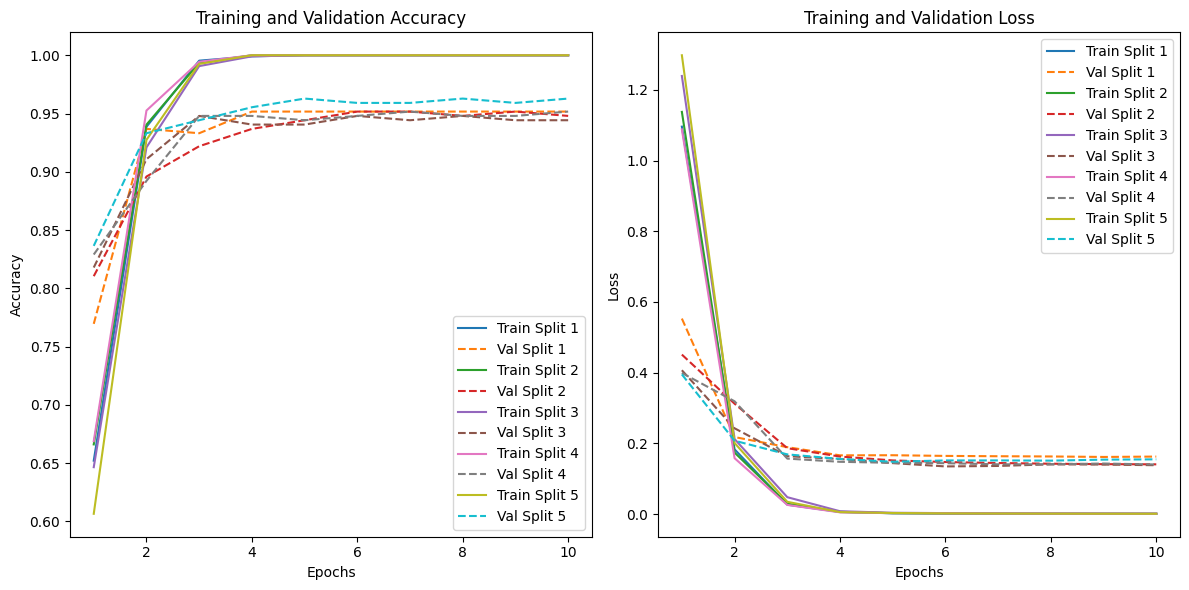

In [9]:
import matplotlib.pyplot as plt

# Determine the maximum length among all lists
max_length = max(len(train_acc) for train_acc in train_acc_list)

# Pad the shorter lists with zeros to match the maximum length
for i in range(n_splits):
    train_acc_list[i] += [0] * (max_length - len(train_acc_list[i]))
    val_acc_list[i] += [0] * (max_length - len(val_acc_list[i]))
    train_loss_list[i] += [0] * (max_length - len(train_loss_list[i]))
    val_loss_list[i] += [0] * (max_length - len(val_loss_list[i]))

# Plotting
epochs = range(1, max_length + 1)

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
for i in range(n_splits):
    plt.plot(epochs, train_acc_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_acc_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(epochs, train_loss_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_loss_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze first 10 convolutional layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    x = base_model.output

    # Adding Conv2D + ReLU Layers
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Adding Max Pooling
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Add GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(x)

    # Replacing the last three layers with new fully connected layers
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(len(sheep_breed_list), activation='softmax')(x)  # Add output layer

    model_normalizedd = Model(inputs=base_model.input, outputs=predictions)

    # Custom learning rates
    lr_mult = {}

    # Set learning rate to 0 for the first 10 layers
    for layer in model_normalizedd.layers[:15]:
        lr_mult[layer.name + '/kernel:0'] = 0.0
        lr_mult[layer.name + '/bias:0'] = 0.0

    # Set learning rate to 0.0001 for the next Conv2D layers and the following layers
    for layer in model_normalizedd.layers[15:30]:
        if isinstance(layer, Conv2D):
            lr_mult[layer.name + '/kernel:0'] = 0.0001
            lr_mult[layer.name + '/bias:0'] = 0.0001

    # Set learning rate to 10 for the last two dense layers
    for layer in model_normalizedd.layers[30:]:
        lr_mult[layer.name + '/kernel:0'] = 1
        lr_mult[layer.name + '/bias:0'] = 1

    # Use SGD optimizer with initial learning rate of 1e-4
    optimizer = SGD(learning_rate=1e-4, momentum=0.9)

    # Compile the model
    model_normalizedd.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[1.] + [10.]*2)

    return model_normalizedd

accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# KFold Cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=777)
fold_var = 1

for train_index, test_index in kf.split(img_data):
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

    model_normalizedd = build_model()

        # Define the ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        width_shift_range=0.1,  # translate horizontally by 10% of total width
        height_shift_range=0.1,  # translate vertically by 10% of total height
        fill_mode='nearest'  # strategy for filling in newly created pixels
    )

    # Generate augmented images batches during training
    train_datagen = datagen.flow(X_train, y_train, batch_size=10)

    #early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
    save_path='/content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/sheepFace_four.keras'
    checkpoint = ModelCheckpoint(save_path,monitor='val_loss',save_best_only=True,verbose=0)
    history = model_normalizedd.fit(train_datagen, epochs=20, validation_data=(X_test,y_test), verbose=1, callbacks=[checkpoint])

    print("\n")
    print(f'Evaluating the Test metrics')
    model_normalizedd=load_model(save_path)
    # Evaluate the model
    scores = model_normalizedd.evaluate(X_test, y_test, verbose=1)
    print(f'Test loss for fold {fold_var}: {scores[0]}')
    print(f'Test accuracy for fold {fold_var}: {scores[1]}')

    accuracy_values.append(scores[1])  # Appending accuracy to the list

    # Get predictions from the model
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to categorical labels
    y_pred = np.argmax(model_normalizedd.predict(X_test), axis=1)  # Get predictions from the model

    # Calculate and append evaluation metrics for this fold
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    # Print evaluation metrics for this fold
    print(f'Precision for fold {fold_var}: {precision}')
    print(f'Recall for fold {fold_var}: {recall}')
    print(f'F1 Score for fold {fold_var}: {f1}')

    train_acc_list.append(history.history['accuracy'])
    val_acc_list.append(history.history['val_accuracy'])
    train_loss_list.append(history.history['loss'])
    val_loss_list.append(history.history['val_loss'])
    print("\n")

    # Increment the fold number
    fold_var += 1

# Calculate standard deviation of accuracy across folds
accuracy_std_dev = np.std(accuracy_values)
print(f'Standard deviation of accuracy across folds: {accuracy_std_dev}')

# Calculate average of accuracy,precision, recall, and F1 across folds
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1 = np.mean(f1_values)

print(f'Average Accuracy across folds: {avg_accuracy}')
print(f'Average Precision across folds: {avg_precision}')
print(f'Average Recall across folds: {avg_recall}')
print(f'Average F1 Score across folds: {avg_f1}')


Epoch 1/20
135/135 [==============================] - 18s 112ms/step - loss: 1.4963 - accuracy: 0.3884 - val_loss: 1.0836 - val_accuracy: 0.5327
Epoch 2/20
135/135 [==============================] - 15s 110ms/step - loss: 1.0848 - accuracy: 0.5603 - val_loss: 0.6992 - val_accuracy: 0.7530
Epoch 3/20
135/135 [==============================] - 14s 102ms/step - loss: 0.8431 - accuracy: 0.6704 - val_loss: 0.9500 - val_accuracy: 0.6071
Epoch 4/20
135/135 [==============================] - 15s 109ms/step - loss: 0.6366 - accuracy: 0.7552 - val_loss: 0.4003 - val_accuracy: 0.8512
Epoch 5/20
135/135 [==============================] - 15s 109ms/step - loss: 0.5589 - accuracy: 0.7917 - val_loss: 0.3772 - val_accuracy: 0.8571
Epoch 6/20
135/135 [==============================] - 14s 106ms/step - loss: 0.4512 - accuracy: 0.8519 - val_loss: 0.5725 - val_accuracy: 0.8006
Epoch 7/20
135/135 [==============================] - 15s 109ms/step - loss: 0.4128 - accuracy: 0.8504 - val_loss: 0.2462 - val_ac

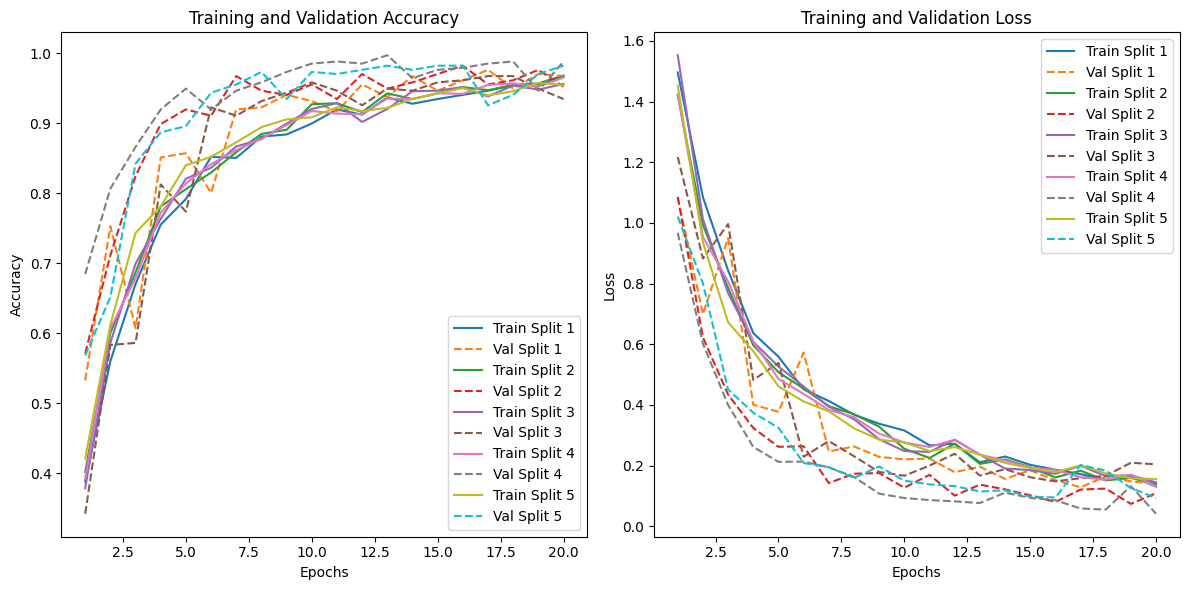

In [16]:
import matplotlib.pyplot as plt

# Determine the maximum length among all lists
max_length = max(len(train_acc) for train_acc in train_acc_list)

# Pad the shorter lists with zeros to match the maximum length
for i in range(n_splits):
    train_acc_list[i] += [0] * (max_length - len(train_acc_list[i]))
    val_acc_list[i] += [0] * (max_length - len(val_acc_list[i]))
    train_loss_list[i] += [0] * (max_length - len(train_loss_list[i]))
    val_loss_list[i] += [0] * (max_length - len(val_loss_list[i]))

# Plotting
epochs = range(1, max_length + 1)

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
for i in range(n_splits):
    plt.plot(epochs, train_acc_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_acc_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(epochs, train_loss_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_loss_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
def build_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze first 10 convolutional layers
    for layer in base_model.layers[:17]:
        layer.trainable = False

    x = base_model.output

    # Flatten to prepare for the fully connected layers
    x = Flatten()(x)

    # Fully connected + ReLU
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)

    # Adding output layer
    predictions = Dense(len(sheep_breed_list), activation='softmax')(x)

    # Create the final model
    model_VGG19 = Model(inputs=base_model.input, outputs=predictions)

    # Custom learning rates
    lr_mult = {}

    # Set learning rate to 0 for the first 10 layers
    for layer in model_VGG19 .layers[:17]:
        lr_mult[layer.name + '/kernel:0'] = 0.0
        lr_mult[layer.name + '/bias:0'] = 0.0

    # Set learning rate to 0.0001 for the next Conv2D layers and the following layers
    for layer in model_VGG19 .layers[17:23]:
        if isinstance(layer, Conv2D):
            lr_mult[layer.name + '/kernel:0'] = 0.001
            lr_mult[layer.name + '/bias:0'] = 0.001

    # Set learning rate to 10 for the last two dense layers
    for layer in model_VGG19 .layers[23:]:
        lr_mult[layer.name + '/kernel:0'] = 0.001
        lr_mult[layer.name + '/bias:0'] = 0.001

    # Use SGD optimizer with initial learning rate of 1e-4
    optimizer = SGD(learning_rate=1e-4,momentum=0.9)

    # Compile the model
    model_VGG19.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[1.] + [10.]*2)

    return model_VGG19

accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# KFold Cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=777)
fold_var = 1

for train_index, test_index in kf.split(img_data):
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

    model_VGG19 = build_model()

    #early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
    save_path='/content/drive/MyDrive/Deep_learning_projects/SheepFace_Data/SheepFace_three.keras'
    checkpoint = ModelCheckpoint(save_path,monitor='val_loss',save_best_only=True,verbose=0)
    history = model_VGG19.fit(X_train, y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.2, callbacks=[checkpoint])

    print("\n")
    print(f'Evaluating the Test metrics')
    model_VGG19=load_model(save_path)
    # Evaluate the model
    scores = model_VGG19.evaluate(X_test, y_test, verbose=1)
    print(f'Test loss for fold {fold_var}: {scores[0]}')
    print(f'Test accuracy for fold {fold_var}: {scores[1]}')

    accuracy_values.append(scores[1])  # Appending accuracy to the list

    # Get predictions from the model
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to categorical labels
    y_pred = np.argmax(model_VGG19.predict(X_test), axis=1)  # Get predictions from the model

    # Calculate and append evaluation metrics for this fold
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    # Print evaluation metrics for this fold
    print(f'Precision for fold {fold_var}: {precision}')
    print(f'Recall for fold {fold_var}: {recall}')
    print(f'F1 Score for fold {fold_var}: {f1}')
    print("\n")

    train_acc_list.append(history.history['accuracy'])
    val_acc_list.append(history.history['val_accuracy'])
    train_loss_list.append(history.history['loss'])
    val_loss_list.append(history.history['val_loss'])

    # Increment the fold number
    fold_var += 1

# Calculate standard deviation of accuracy across folds
accuracy_std_dev = np.std(accuracy_values)
print(f'Standard deviation of accuracy across folds: {accuracy_std_dev}')

# Calculate average of accuracy,precision, recall, and F1 across folds
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1 = np.mean(f1_values)

print(f'Average Accuracy across folds: {avg_accuracy}')
print(f'Average Precision across folds: {avg_precision}')
print(f'Average Recall across folds: {avg_recall}')
print(f'Average F1 Score across folds: {avg_f1}')


80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/10
108/108 [==============================] - 33s 295ms/step - loss: 0.9192 - accuracy: 0.7293 - val_loss: 0.2874 - val_accuracy: 0.8736
Epoch 2/10
108/108 [==============================] - 11s 103ms/step - loss: 0.0734 - accuracy: 0.9786 - val_loss: 0.2228 - val_accuracy: 0.9071
Epoch 3/10
108/108 [==============================] - 11s 103ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1990 - val_accuracy: 0.9294
Epoch 4/10
108/108 [==============================] - 11s 104ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1823 - val_accuracy: 0.9368
Epoch 5/10
108/108 [==============================] - 11s 105ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1803 - val_accuracy: 0.9368
Epoch 6/10
108/108 [==============================] - 11s 106ms/step - loss: 8.3498e-04 - accuracy: 1.0000 - val_loss: 0.1789 - val_accuracy: 0.9368
Epoch 7/10
108/108 [==============================] - 11s 106

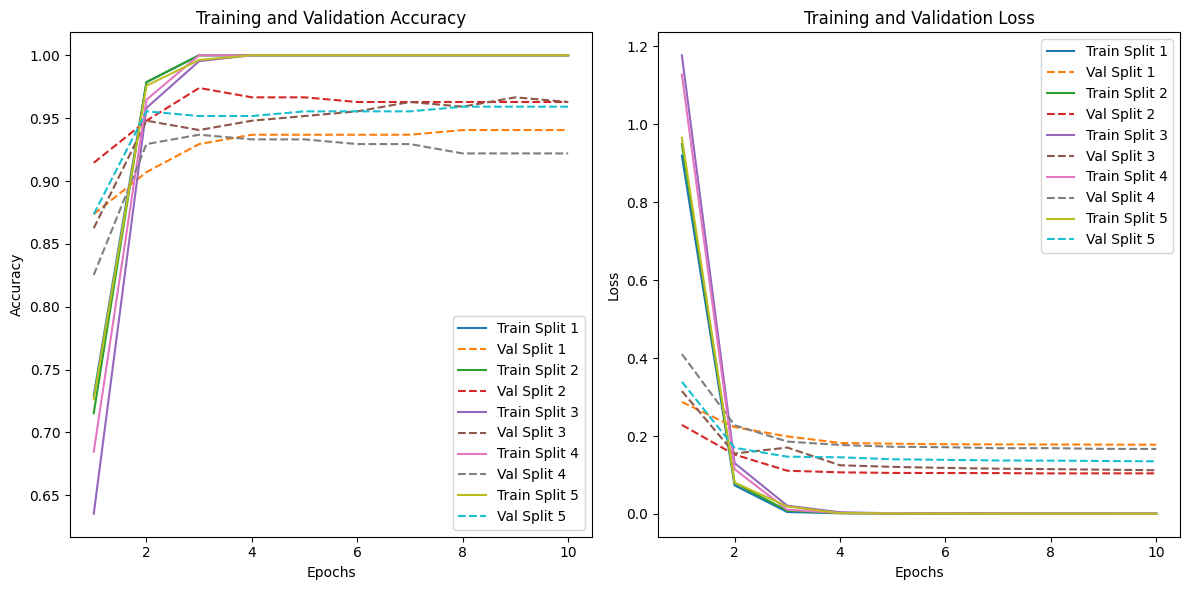

In [11]:
import matplotlib.pyplot as plt

# Determine the maximum length among all lists
max_length = max(len(train_acc) for train_acc in train_acc_list)

# Pad the shorter lists with zeros to match the maximum length
for i in range(n_splits):
    train_acc_list[i] += [0] * (max_length - len(train_acc_list[i]))
    val_acc_list[i] += [0] * (max_length - len(val_acc_list[i]))
    train_loss_list[i] += [0] * (max_length - len(train_loss_list[i]))
    val_loss_list[i] += [0] * (max_length - len(val_loss_list[i]))

# Plotting
epochs = range(1, max_length + 1)

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
for i in range(n_splits):
    plt.plot(epochs, train_acc_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_acc_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(epochs, train_loss_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_loss_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Load the pre-trained VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Define SVM pipeline
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='linear', probability=True))])

# Initialize lists to store evaluation metrics
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Perform k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
fold_var = 1

for train_index, test_index in skf.split(img_data, labels_encoded):  # Ensure labels_encoded is defined correctly as the non-categorical labels
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels_encoded[train_index], labels_encoded[test_index]

    # Extract features using the VGG16 model and flatten them
    X_train_features = base_model.predict(preprocess_input(X_train))
    X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)

    X_test_features = base_model.predict(preprocess_input(X_test))
    X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

    # Fit and transform the training data with StandardScaler and train the SVM
    svm_pipeline.fit(X_train_features, y_train)

    # Predict using the trained SVM pipeline
    predictions = svm_pipeline.predict(X_test_features)
    print(f'Fold {fold_var}:')
    print(f'Accuracy: {accuracy_score(y_test, predictions)}')
    print(f'Precision: {precision_score(y_test, predictions, average="weighted")}')
    print(f'Recall: {recall_score(y_test, predictions, average="weighted")}')
    print(f'F1 Score: {f1_score(y_test, predictions, average="weighted")}')

    # Calculate evaluation metrics
    accuracy_values.append(accuracy_score(y_test, predictions))
    precision_values.append(precision_score(y_test, predictions, average='weighted'))
    recall_values.append(recall_score(y_test, predictions, average='weighted'))
    f1_values.append(f1_score(y_test, predictions, average='weighted'))

    # Increment the fold number
    fold_var += 1

# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1 = np.mean(f1_values)

print(f'Average test Accuracy across folds: {avg_accuracy}')
print(f'Average Precision across folds: {avg_precision}')
print(f'Average Recall across folds: {avg_recall}')
print(f'Average F1 Score across folds: {avg_f1}')


11/11 [==============================] - 5s 474ms/step
Fold 1:
Accuracy: 0.9553571428571429
Precision: 0.9558990724255652
Recall: 0.9553571428571429
F1 Score: 0.9548037603627753
11/11 [==============================] - 1s 116ms/step
Fold 2:
Accuracy: 0.9702380952380952
Precision: 0.9702761627906978
Recall: 0.9702380952380952
F1 Score: 0.9700502152080345
11/11 [==============================] - 1s 120ms/step
Fold 3:
Accuracy: 0.9732142857142857
Precision: 0.9734078992890944
Recall: 0.9732142857142857
F1 Score: 0.9731926934849087
11/11 [==============================] - 1s 125ms/step
Fold 4:
Accuracy: 0.9642857142857143
Precision: 0.965298202614379
Recall: 0.9642857142857143
F1 Score: 0.9642785203194726
11/11 [==============================] - 1s 128ms/step
Fold 5:
Accuracy: 0.9791666666666666
Precision: 0.9793767507002801
Recall: 0.9791666666666666
F1 Score: 0.9792188619227544
Average test Accuracy across folds: 0.9684523809523811
Average Precision across folds: 0.9688516175640034
Avera

In [13]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab_Notebooks/Sheep_Face_Classification.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/Sheep_Face_Classification.ipynb to pdf
[NbConvertApp] Support files will be in Sheep_Face_Classification_files/
[NbConvertApp] Making directory ./Sheep_Face_Classification_files
[NbConvertApp] Making directory ./Sheep_Face_Classification_files
[NbConvertApp] Making directory ./Sheep_Face_Classification_files
[NbConvertApp] Writing 153610 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 476572 bytes to /content/drive/MyDrive/Colab_Notebooks/Sheep_Face_Classification.pdf


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 10 convolutional layers
for layer in base_model.layers[:15]:
    layer.trainable = False

x = base_model.output

# Adding Conv2D + ReLU Layers
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Adding Max Pooling
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Add GlobalAveragePooling2D layer
x = GlobalAveragePooling2D()(x)

# Replacing the last three layers with new fully connected layers
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(len(sheep_breed_list), activation='softmax')(x)  # Add output layer

model_normalizedd = Model(inputs=base_model.input, outputs=predictions)

# Custom learning rates
lr_mult = {}

# Set learning rate to 0 for the first 10 layers
for layer in model_normalizedd.layers[:15]:
    lr_mult[layer.name + '/kernel:0'] = 0.0
    lr_mult[layer.name + '/bias:0'] = 0.0

# Set learning rate to 0.0001 for the next Conv2D layers and the following layers
for layer in model_normalizedd.layers[15:30]:
    if isinstance(layer, Conv2D):
        lr_mult[layer.name + '/kernel:0'] = 0.0001
        lr_mult[layer.name + '/bias:0'] = 0.0001

# Set learning rate to 10 for the last two dense layers
for layer in model_normalizedd.layers[30:]:
    lr_mult[layer.name + '/kernel:0'] = 1
    lr_mult[layer.name + '/bias:0'] = 1

# Use SGD optimizer with initial learning rate of 1e-4
optimizer = SGD(learning_rate=1e-4, momentum=0.9)

# Compile the model
model_normalizedd.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[1.] + [10.]*2)

58889256/58889256 [==============================] - 0s 0us/step


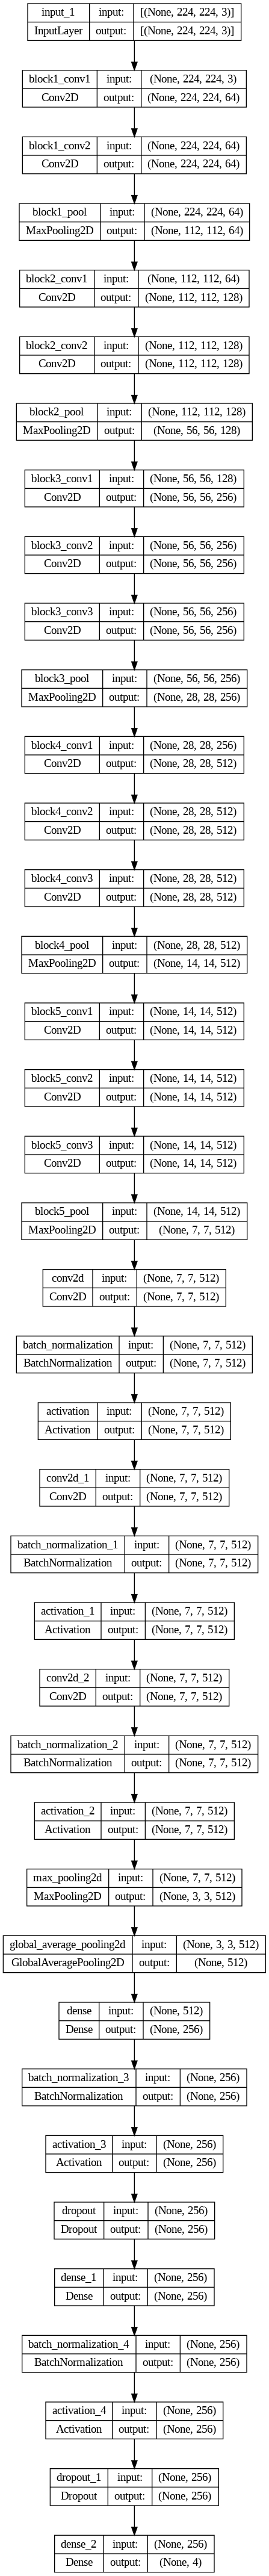

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model_normalizedd, to_file='model.png', show_shapes=True)

In [18]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 10 convolutional layers
for layer in base_model.layers[:17]:
    layer.trainable = False

x = base_model.output

# Flatten to prepare for the fully connected layers
x = Flatten()(x)

# Fully connected + ReLU
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)

# Adding output layer
predictions = Dense(len(sheep_breed_list), activation='softmax')(x)

# Create the final model
model_VGG19 = Model(inputs=base_model.input, outputs=predictions)

# Custom learning rates
lr_mult = {}

# Set learning rate to 0 for the first 10 layers
for layer in model_VGG19 .layers[:17]:
    lr_mult[layer.name + '/kernel:0'] = 0.0
    lr_mult[layer.name + '/bias:0'] = 0.0

# Set learning rate to 0.0001 for the next Conv2D layers and the following layers
for layer in model_VGG19 .layers[17:23]:
    if isinstance(layer, Conv2D):
        lr_mult[layer.name + '/kernel:0'] = 0.001
        lr_mult[layer.name + '/bias:0'] = 0.001

# Set learning rate to 10 for the last two dense layers
for layer in model_VGG19 .layers[23:]:
    lr_mult[layer.name + '/kernel:0'] = 0.001
    lr_mult[layer.name + '/bias:0'] = 0.001

# Use SGD optimizer with initial learning rate of 1e-4
optimizer = SGD(learning_rate=1e-4,momentum=0.9)

# Compile the model
model_VGG19.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[1.] + [10.]*2)

In [19]:
model_VGG19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

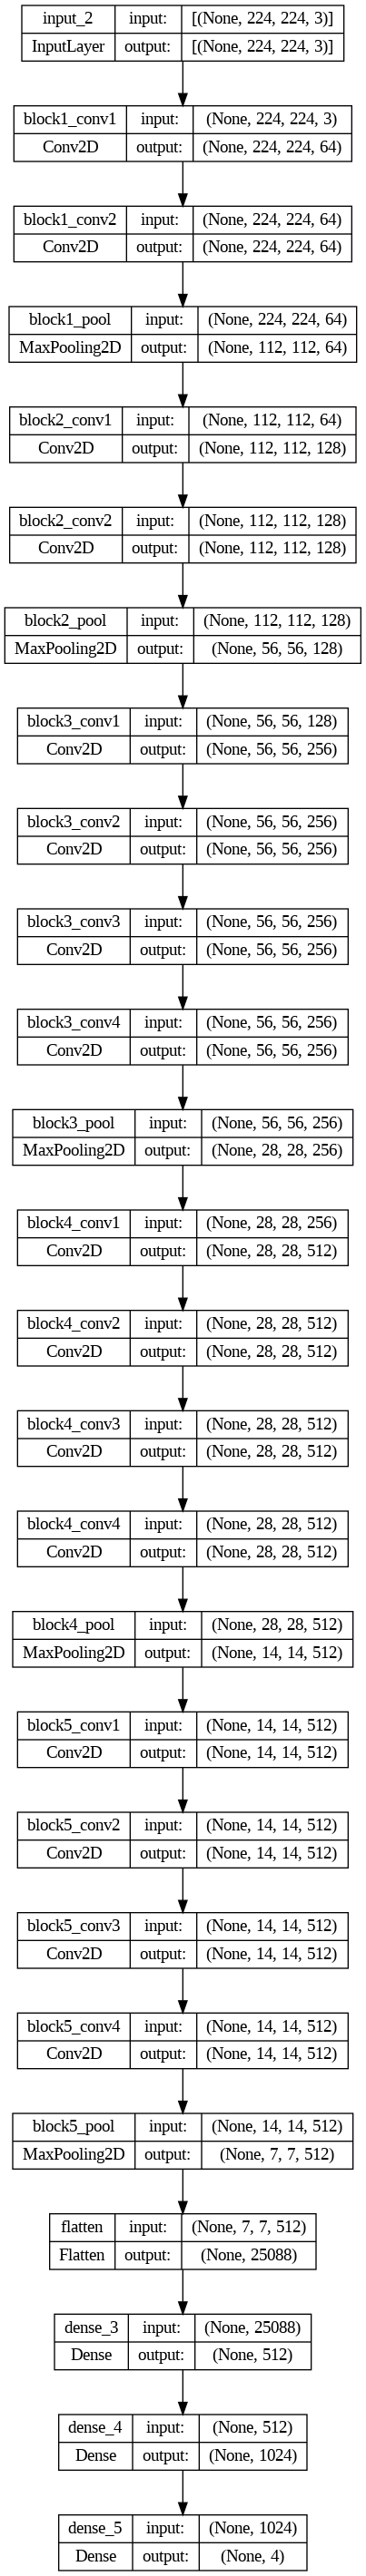

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model_VGG19, to_file='model.png', show_shapes=True)